In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd

Data source can be found at:

[laptop-price-dataset](https://www.kaggle.com/datasets/asinow/laptop-price-dataset)

# Laptop Price Prediction
In this notebook, we will build a predictive model to estimate the price of laptops based on various hardware specifications and features. The dataset contains real-world data, reflecting the factors that influence laptop prices, and will guide us through data exploration, model building, optimization, and testing.

## About the Dataset
This dataset contains 11,768 records of laptops, with each record representing a different laptop model. It includes features such as processor type, RAM size, storage type, GPU, screen size, resolution, battery life, weight, operating system, and the laptop's price.

### Dataset Columns:
* **Brand**: The manufacturer of the laptop (e.g., Dell, HP, Apple, Asus, Lenovo).
* **Processor**: The CPU model, which can include Intel (i3, i5, i7, i9) and AMD Ryzen (3, 5, 7, 9).
* **RAM (GB)**: The laptop's memory size (e.g., 4GB, 8GB, 16GB, 32GB, 64GB).
* **Storage**: Type and size of storage (e.g., 256GB SSD, 512GB SSD, 1TB HDD).
* **GPU**: The graphics processing unit, either integrated or dedicated (e.g., Nvidia GTX 1650, RTX 3060).
* **Screen Size (inch)**: The display size in inches (e.g., 13.3", 14", 15.6", 17.3").
* **Resolution**: The screen resolution (e.g., 1366x768, 1920x1080, 2560x1440, or 3840x2160).
* **Battery Life (hours)**: Estimated battery life in hours, ranging from 4 to 12 hours.
* **Weight (kg)**: The weight of the laptop in kilograms (ranging from 1.2kg to 3.5kg).
* **Operating System**: The pre-installed OS, such as Windows, macOS, Linux, and FreeDOS.
* **Price ($)**: The target variable, representing the laptop's price in US dollars.


The notebook will follow the steps below to build a model for predicting laptop prices:

1. **Data Exploration**:
* Explore and understand the dataset, check for missing values, data distributions, and any correlations between features.
2. **Pipeline Building**:
* Construct a data pipeline that includes preprocessing steps (e.g., scaling, encoding categorical variables), followed by a machine learning model.
3. **Model Selection**:
* Choose an appropriate regression model based on the nature of the data and the problem at hand.
4. **Model Optimization (Grid Search)**:
* Optimize the model's hyperparameters using grid search to improve performance.
5. **Model Testing**:
* Evaluate the final model on the test set and assess its predictive accuracy and performance metrics.

By the end of this notebook, we will have a trained model capable of predicting laptop prices based on the provided features.

***Let's get started!***

# Data Exploration

In [3]:
#Read csv
laptops = pd.read_csv('/kaggle/input/laptop-price-dataset/laptop_prices.csv')

## First lets change the column names for easier handeling
e.g., `RAM (GB)` to  `ram_gb`

In [4]:
laptops = laptops.rename(columns={
    'Brand': 'brand',
    'Processor': 'processor',
    'RAM (GB)': 'ram_gb',
    'Storage': 'storage',
    'GPU': 'gpu',
    'Screen Size (inch)': 'screen_size_inch',
    'Resolution': 'resolution',
    'Battery Life (hours)': 'battery_life_hours',
    'Weight (kg)': 'weight_kg',
    'Operating System': 'operating_system',
    'Price ($)': 'price',
})

In [5]:
laptops.head()

,brand,processor,ram_gb,storage,gpu,screen_size_inch,resolution,battery_life_hours,weight_kg,operating_system,price
0,Apple,AMD Ryzen 3,64,512GB SSD,Nvidia GTX 1650,17.3,2560x1440,8.9,1.42,FreeDOS,3997.07
1,Razer,AMD Ryzen 7,4,1TB SSD,Nvidia RTX 3080,14.0,1366x768,9.4,2.57,Linux,1355.78
2,Asus,Intel i5,32,2TB SSD,Nvidia RTX 3060,13.3,3840x2160,8.5,1.74,FreeDOS,2673.07
3,Lenovo,Intel i5,4,256GB SSD,Nvidia RTX 3080,13.3,1366x768,10.5,3.10,Windows,751.17
4,Razer,Intel i3,4,256GB SSD,AMD Radeon RX 6600,16.0,3840x2160,5.7,3.38,Linux,2059.83


In [6]:
laptops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11768 entries, 0 to 11767
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brand               11768 non-null  object 
 1   processor           11768 non-null  object 
 2   ram_gb              11768 non-null  int64  
 3   storage             11768 non-null  object 
 4   gpu                 11768 non-null  object 
 5   screen_size_inch    11768 non-null  float64
 6   resolution          11768 non-null  object 
 7   battery_life_hours  11768 non-null  float64
 8   weight_kg           11768 non-null  float64
 9   operating_system    11768 non-null  object 
 10  price               11768 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 1011.4+ KB


## Lets have a quick look at missing values

In [7]:
laptops.isnull().sum()#Non have null

brand                 0
processor             0
ram_gb                0
storage               0
gpu                   0
screen_size_inch      0
resolution            0
battery_life_hours    0
weight_kg             0
operating_system      0
price                 0
dtype: int64

No missing values

## Lets look at the categorical variables

In [8]:
def filter_categorical_variables(df):
  """
  Filters a Pandas DataFrame to include only categorical variables.

  Args:
    df: The input Pandas DataFrame.

  Returns:
    A new DataFrame containing only the categorical variables, 
    or an empty DataFrame if there are no categorical variables.
  """
  categorical_columns = df.select_dtypes(include=['object', 'category']).columns
  return df[categorical_columns]

In [9]:
laptops_cat = filter_categorical_variables(laptops)
laptops_cat.head()

,brand,processor,storage,gpu,resolution,operating_system
0,Apple,AMD Ryzen 3,512GB SSD,Nvidia GTX 1650,2560x1440,FreeDOS
1,Razer,AMD Ryzen 7,1TB SSD,Nvidia RTX 3080,1366x768,Linux
2,Asus,Intel i5,2TB SSD,Nvidia RTX 3060,3840x2160,FreeDOS
3,Lenovo,Intel i5,256GB SSD,Nvidia RTX 3080,1366x768,Windows
4,Razer,Intel i3,256GB SSD,AMD Radeon RX 6600,3840x2160,Linux


In [10]:
for cat in laptops_cat.columns:
    unique_cat = laptops_cat[cat].unique()
    print(f'Variable {cat} has {len(unique_cat)} unique values. These values are: {unique_cat}')

Variable brand has 10 unique values. These values are: ['Apple' 'Razer' 'Asus' 'Lenovo' 'Acer' 'Dell' 'Microsoft' 'HP' 'Samsung'
 'MSI']
Variable processor has 8 unique values. These values are: ['AMD Ryzen 3' 'AMD Ryzen 7' 'Intel i5' 'Intel i3' 'AMD Ryzen 9'
 'AMD Ryzen 5' 'Intel i9' 'Intel i7']
Variable storage has 5 unique values. These values are: ['512GB SSD' '1TB SSD' '2TB SSD' '256GB SSD' '1TB HDD']
Variable gpu has 7 unique values. These values are: ['Nvidia GTX 1650' 'Nvidia RTX 3080' 'Nvidia RTX 3060'
 'AMD Radeon RX 6600' 'Nvidia RTX 2060' 'AMD Radeon RX 6800' 'Integrated']
Variable resolution has 4 unique values. These values are: ['2560x1440' '1366x768' '3840x2160' '1920x1080']
Variable operating_system has 4 unique values. These values are: ['FreeDOS' 'Linux' 'Windows' 'macOS']


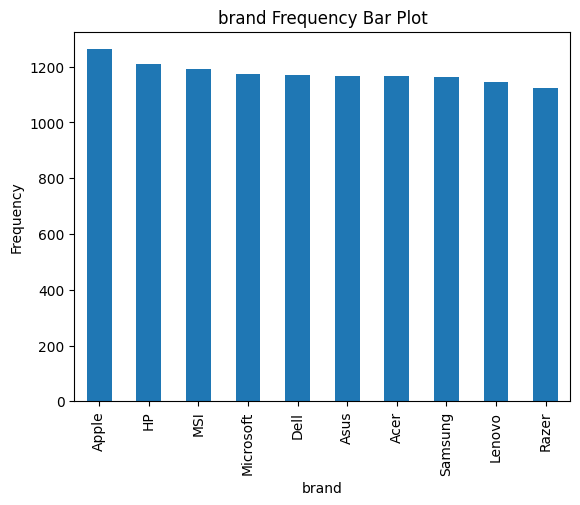

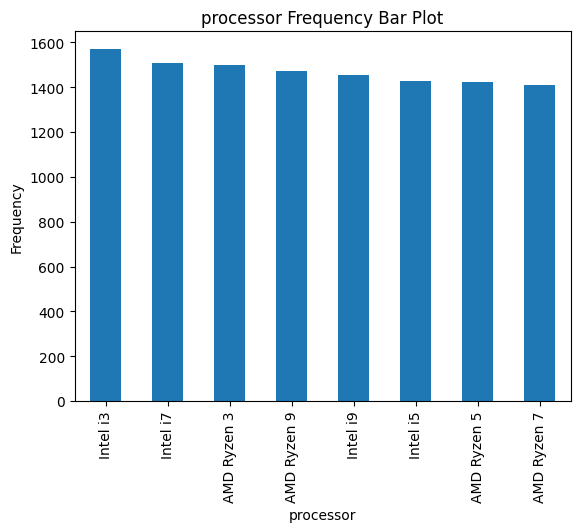

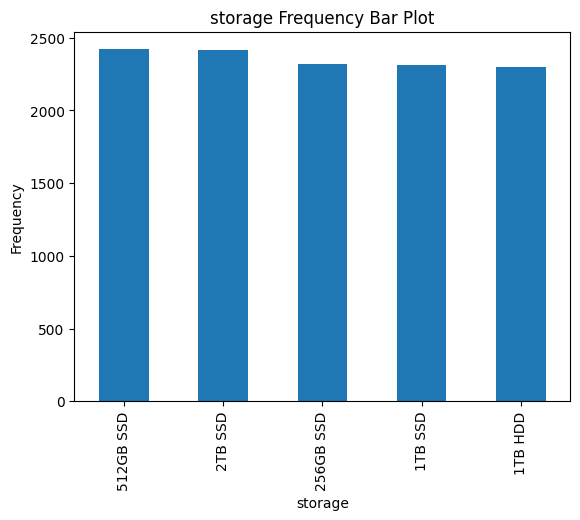

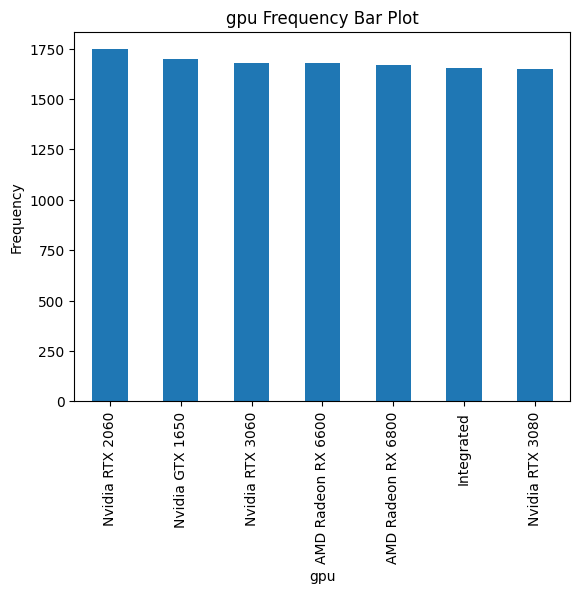

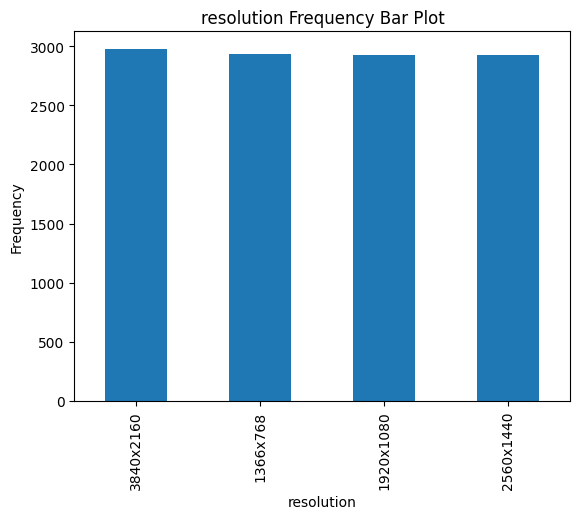

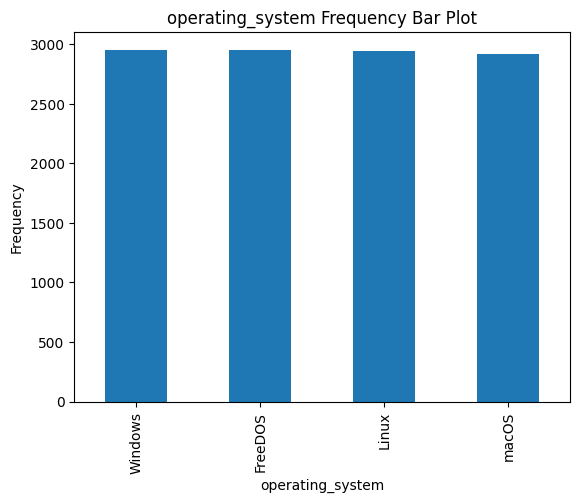

In [11]:
for cat in laptops_cat.columns:
    cat_freq = laptops_cat[cat].value_counts()
    cat_freq.plot(kind='bar')
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.title(f"{cat} Frequency Bar Plot")
    plt.show()
    

**All categorical varialbes seem to have a few unique values and evenly distributed.**

## Lets look at the numeric varialbes

In [12]:
def filter_numeric_variables(df):
  """
  Filters a Pandas DataFrame to include only numeric variables.

  Args:
    df: The input Pandas DataFrame.

  Returns:
    A new DataFrame containing only the numeric variables, 
    or an empty DataFrame if there are no numeric variables.
  """
  numeric_columns = df.select_dtypes(include=['number']).columns
  return df[numeric_columns]

In [13]:
laptops_num = filter_numeric_variables(laptops)

In [14]:
laptops_num.head()

,ram_gb,screen_size_inch,battery_life_hours,weight_kg,price
0,64,17.3,8.9,1.42,3997.07
1,4,14.0,9.4,2.57,1355.78
2,32,13.3,8.5,1.74,2673.07
3,4,13.3,10.5,3.10,751.17
4,4,16.0,5.7,3.38,2059.83


In [15]:
laptops_num.describe()#Description of numeric variables

,ram_gb,screen_size_inch,battery_life_hours,weight_kg,price
count,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000
mean,24.852821,15.212305,8.027855,2.341117,2183.571608
std,21.762567,1.436997,2.305400,0.667921,1316.886132
min,4.000000,13.300000,4.000000,1.200000,279.570000
25%,8.000000,14.000000,6.000000,1.760000,1272.045000
50%,16.000000,15.600000,8.000000,2.340000,1840.865000
75%,32.000000,16.000000,10.000000,2.910000,2698.370000
max,64.000000,17.300000,12.000000,3.500000,10807.880000


array([[<Axes: title={'center': 'ram_gb'}>,
        <Axes: title={'center': 'screen_size_inch'}>],
       [<Axes: title={'center': 'battery_life_hours'}>,
        <Axes: title={'center': 'weight_kg'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

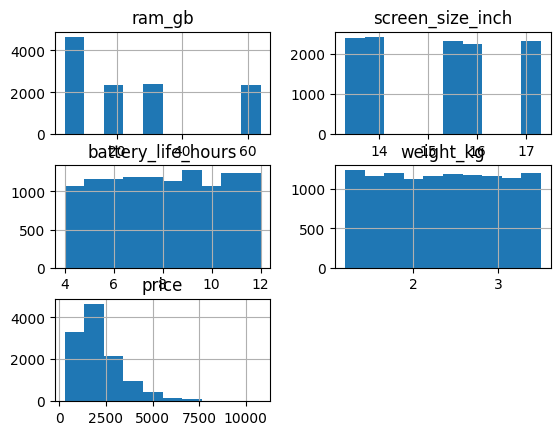

In [16]:
laptops_num.hist()

## Lets look at the correlation between variables

In [17]:
laptops_num.corr()

,ram_gb,screen_size_inch,battery_life_hours,weight_kg,price
ram_gb,1.000000,0.007915,0.012470,-0.001716,0.616221
screen_size_inch,0.007915,1.000000,0.008348,-0.015508,0.069829
battery_life_hours,0.012470,0.008348,1.000000,-0.001774,0.009778
weight_kg,-0.001716,-0.015508,-0.001774,1.000000,0.002431
price,0.616221,0.069829,0.009778,0.002431,1.000000


**RAM seems to be in a strong positive correlation with price. Other then than, no other variables seem to be related to price and/or to each other**

In [18]:
laptops_num = laptops_num.drop(columns=['price'])#Removing price from numeric columns as we don't want to touch it from this point.

# Building the pipeline

In [19]:
# Define preprocessing for numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), list(laptops_cat.columns)),  # OneHotEncoder for 'color'
        ('num', StandardScaler(), list(laptops_num.columns))  # StandardScaler for numeric columns
    ])

In [20]:
y = laptops['price']
X = laptops.drop('price',axis=1)

In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model selection
Let's go through some regressions to see which one gives us the best scores. We will use Negative MSE for our scoring metric

## Linear regresion

In [22]:
# Define the full pipeline: Preprocessing + Linear Regression
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Apply linear regression after preprocessing
])

In [23]:
scores = cross_val_score(linear_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Negative MSE: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Negative MSE: -203918.86 with a standard deviation of 9936.02


## DecisionTreeRegressor

In [24]:
# Define the full pipeline: Preprocessing + Regression model
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', tree.DecisionTreeRegressor(random_state=42))  # Apply linear regression after preprocessing
])

In [25]:
scores = cross_val_score(tree_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Negative MSE: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Negative MSE: -92021.72 with a standard deviation of 8427.52


## RandomForestRegressor

In [26]:
# Define the full pipeline: Preprocessing + Linear Regression
forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', tree.DecisionTreeRegressor(max_depth=2, random_state=42))  # Apply linear regression after preprocessing
])

In [27]:
scores = cross_val_score(forest_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Negative MSE: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Negative MSE: -943228.39 with a standard deviation of 30382.35


## SVR

In [28]:
# Define the full pipeline: Preprocessing + Linear Regression
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(C=1.0, epsilon=0.2,kernel='linear'))  # Apply linear regression after preprocessing
])

In [29]:
scores = cross_val_score(svr_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Negative MSE: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


Negative MSE: -409197.72 with a standard deviation of 29543.32


# Model Optimization (Grid Search)

* The best model was the **Decision tree** model
* Let's find the best fit model in terms of minimizing the **mean squared error (MSE)** 

In [30]:
# Create the parameter grid
param_grid = {
    'regressor__max_depth': [3, 5, 7, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__ccp_alpha': [0.0, 0.01, 0.1]
}

# Initialize Grid Search
grid_search = GridSearchCV(tree_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit and Evaluate
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'regressor__ccp_alpha': 0.0, 'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10}
Best score: -81345.57327693343


# Model evaluation on test data

In [31]:
grid_search.score(X_test,y_test)

-62007.64723744441

In [32]:
y_pred = grid_search.predict(X_test)

**As can be seen from the plot we have managed to build a good model to predict laptop price**

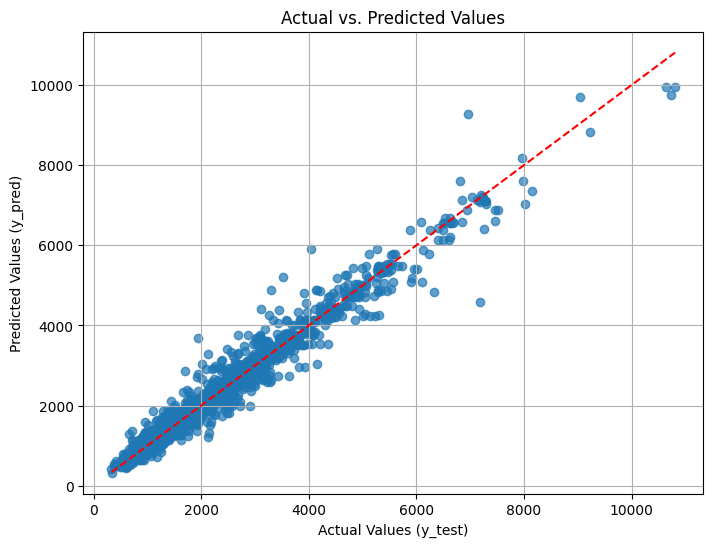

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') # Diagonal line
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Actual vs. Predicted Values")
plt.grid(True)
plt.show()